In [94]:
import numpy as np
import pandas as pd
import importlib
import data_loader
import gibbs_sampler
importlib.reload(data_loader)
importlib.reload(gibbs_sampler)
from data_loader import CountryDataLoader
from gibbs_sampler import HierarchicalGibbsSampler
from scipy.sparse import block_diag as sparse_block_diag
import os

In [92]:
# Display the current working directory
print("Current working directory:", os.getcwd())

# Specify the path to the Parquet file
file_path = 'C:/Users/frede/Desktop/Bachelor Data/countries/usa.parquet'

# Read the Parquet file
df = pd.read_parquet(file_path)

# Display the first few rows of the DataFrame
# Display all the column names
df["eom"].min()

Current working directory: c:\Users\frede\Desktop\Bachelor\src


np.int64(19251231)

In [95]:
file_path = 'C:/Users/frede/Desktop/Bachelor Data/Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]



loader.load_data(split_date="19321231")  # or 
pre_data = loader.pretrain_dict
train_data = loader.train_dict
X_dict_pre = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.pretrain_dict.items()
}

Y_dict_pre = {
    c: df["y"].to_numpy()
    for c, df in loader.pretrain_dict.items()
}

X_pre = np.vstack([X_dict_pre[c] for c in X_dict_pre])
Y_pre = np.concatenate([Y_dict_pre[c] for c in Y_dict_pre])
Z_pre = sparse_block_diag([X_dict_pre[c] for c in X_dict_pre]).tocsr()


# --- Train data ---
X_dict = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.train_dict.items()
}

Y_dict = {
    c: df["y"].to_numpy()
    for c, df in loader.train_dict.items()
}

X = np.vstack([X_dict[c] for c in X_dict])
Y = np.concatenate([Y_dict[c] for c in Y_dict])
Z = sparse_block_diag([X_dict[c] for c in X_dict]).tocsr()



In [97]:
pre_data["usa"]["eom"].min()

Timestamp('1925-12-31 00:00:00')

In [98]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1e-6, fit_intercept=False)  # very weak prior
ridge.fit(X_pre, Y_pre)

theta_g_ridge = ridge.coef_
residuals = Y_pre - X_pre @ theta_g_ridge


In [99]:
theta_g_ridge

array([-1.26590746e-02, -9.64475924e-03, -4.67629968e-04, -3.01443941e-03,
       -7.29223611e-03, -2.05713226e-02, -9.11924499e-03, -1.38399258e-03,
       -9.32048054e-04, -9.16511888e+00,  2.66479453e-04, -2.18436415e-02,
       -2.72764541e-03, -3.42868749e-02,  1.65783235e-03, -7.93142188e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [100]:
# τ²: variance of global parameters (plus a bit of slack)
tau_theta_g_sq = np.var(theta_g_ridge) + 1e-3

# σ² ~ InvGamma(α, β), estimate via residual variance
resid_var = np.var(residuals)
alpha_sigma = 2.0
beta_sigma = resid_var / alpha_sigma

# Λ_c ~ Gamma(α, β) prior: set α * β = τ²
alpha_lambda = 2.0
beta_lambda = tau_theta_g_sq / alpha_lambda

# Wishart prior: mean(diag(Sigma)) = τ²
Sigma = tau_theta_g_sq * np.eye(X_pre.shape[1])
nu = X_pre.shape[1] + 2


n_iter = 1000
burn_in = 100


In [101]:
sampler = HierarchicalGibbsSampler(
    X_dict=X_dict,
    Y_dict=Y_dict,
    X=X,
    Y=Y,
    Z=Z,
    n_iter=n_iter,
    burn_in=burn_in,
    tau_theta_g_sq=tau_theta_g_sq,
    alpha_sigma=alpha_sigma,
    beta_sigma=beta_sigma,
    hyper_type="wishart",  # or "gamma"
    alpha_lambda=alpha_lambda,
    beta_lambda=beta_lambda,
    Sigma=Sigma,
    nu=nu
)

sampler.run()

100%|██████████| 1000/1000 [47:36<00:00,  2.86s/it]


In [102]:
theta_g_samples = sampler.get_posterior_samples()["theta_g"]
theta_l_samples = sampler.get_posterior_samples()["theta_l"]
country_codes = sorted(sampler.X_dict.keys())


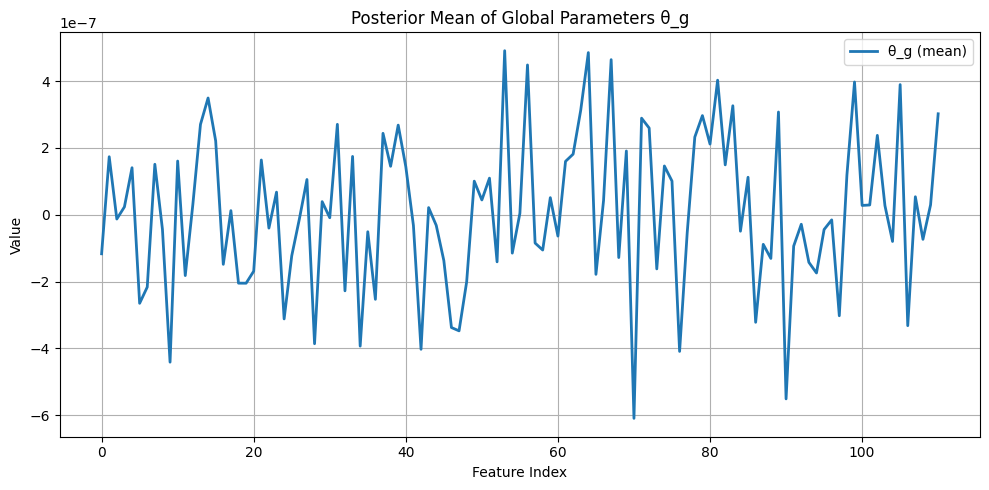

In [103]:
import matplotlib.pyplot as plt

theta_g_mean = sampler.get_posterior_means()["theta_g"]
plt.figure(figsize=(10, 5))
plt.plot(theta_g_mean, label="θ_g (mean)", linewidth=2)
plt.title("Posterior Mean of Global Parameters θ_g")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [104]:
theta_g_mean.max()

np.float64(4.907487626402e-07)

C:\Users\frede\AppData\Local\Temp\ipykernel_8992\352141160.py:15: UserWarning: Glyph 119970 (\N{MATHEMATICAL SCRIPT CAPITAL G}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\frede\Desktop\Bachelor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 119970 (\N{MATHEMATICAL SCRIPT CAPITAL G}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


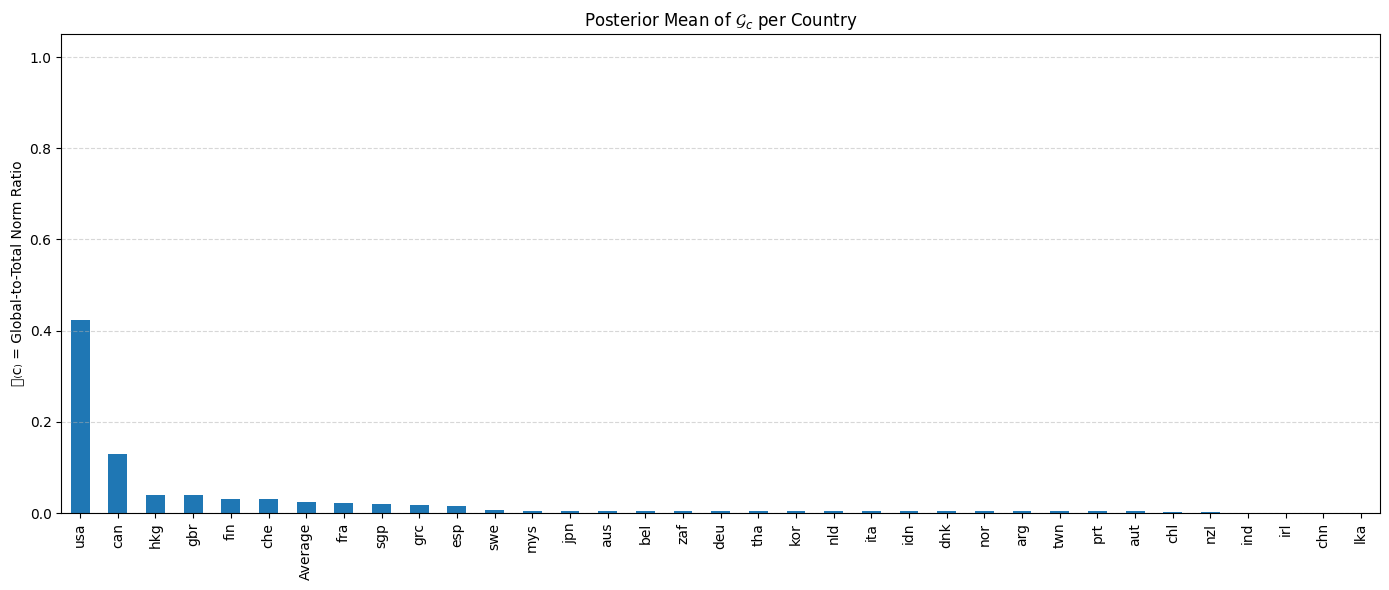

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Gc_mean = sampler.get_posterior_mean_Gc()
Gc_mean["Average"] = np.mean(list(Gc_mean.values()))

pd.Series(Gc_mean).sort_values(ascending=False).plot(kind="bar", figsize=(14, 6))
plt.title("Posterior Mean of $\\mathcal{G}_c$ per Country")
plt.ylabel("𝒢₍c₎ = Global-to-Total Norm Ratio")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




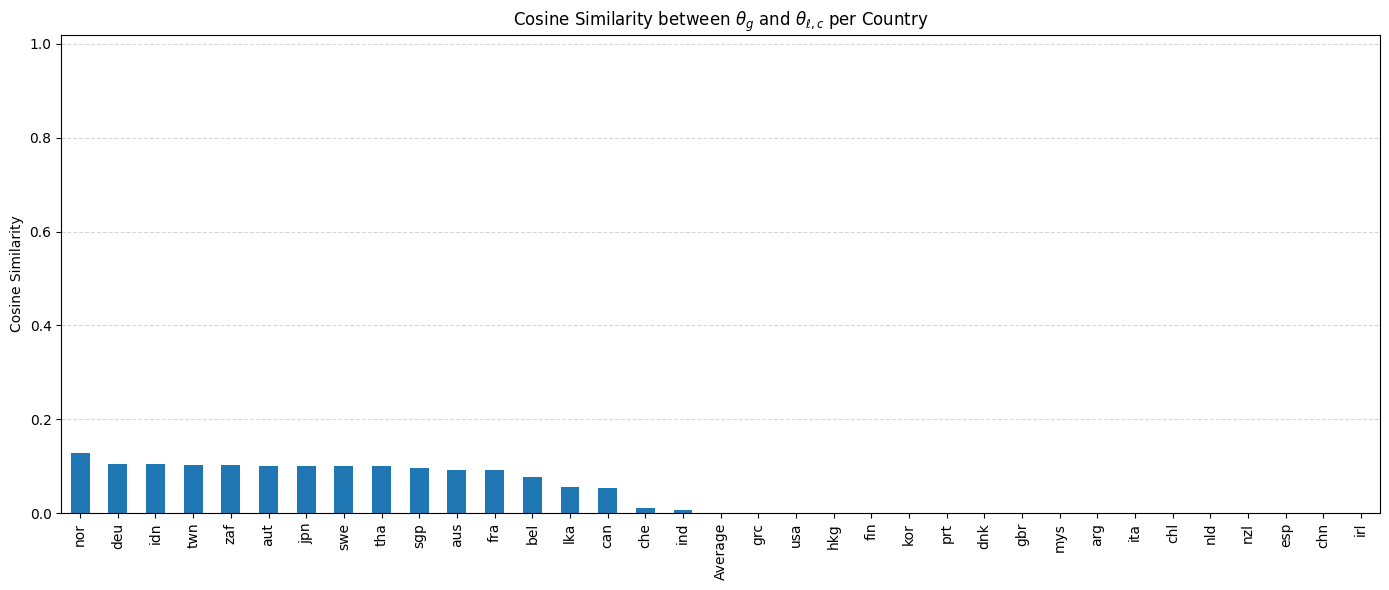

In [106]:
posterior = sampler.get_posterior_means()
theta_g = posterior["theta_g"]
theta_l = posterior["theta_l"]

cos_sim = {
    c: cosine_similarity(theta_g.reshape(1, -1), theta_l[c].reshape(1, -1))[0, 0]
    for c in theta_l
}

# Optional: Add average
cos_sim["Average"] = np.mean(list(cos_sim.values()))

# Plot
cos_sim_series = pd.Series(cos_sim).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
cos_sim_series.plot(kind="bar")
plt.title("Cosine Similarity between $\\theta_g$ and $\\theta_{\\ell,c}$ per Country")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=90)
plt.ylim(0.0, 1.02)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [109]:
posterior = sampler.get_posterior_means()
theta_g = posterior["theta_g"]
theta_l = posterior["theta_l"]


In [ ]:
file_path = 'C:/Users/frede/Desktop/Bachelor Data/Test'

loader_predict = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="test"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]
# --- Train data ---

loader_predict.load_data(split_date=None)

X_test = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader_predict.data_dict.items()
}

Y_test = {
    c: df["y"].to_numpy()
    for c, df in loader_predict.data_dict.items()
}


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

y_true_all = []
y_pred_all = []

for c in X_dict_test:
    X_c = X_dict_test[c]
    y_c = Y_dict_test[c]

    if c not in theta_l:
        continue  # skip countries not in training set

    theta_total = theta_g + theta_l[c]
    y_pred = X_c @ theta_total

    y_true_all.append(y_c)
    y_pred_all.append(y_pred)

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)
